# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

The code has been adapted from the excellent [PixelCNN tutorial](https://keras.io/examples/generative/pixelcnn/) created by ADMoreau, available on the Keras website.

In [ ]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%load_ext autoreload
#%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

#from notebooks.utils import display

## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare the data <a name="prepare"></a>

In [ ]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

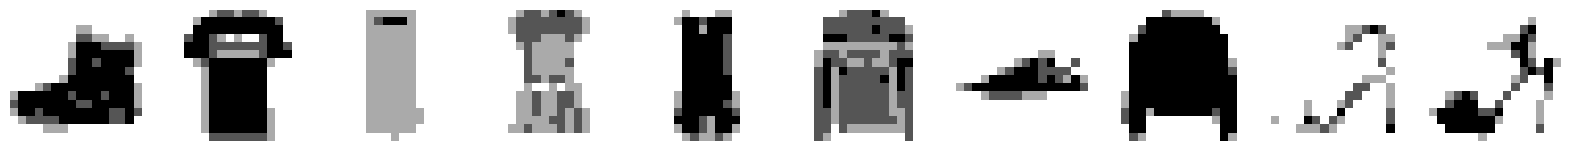

In [ ]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN

In [ ]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [ ]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2  (None, 16, 16, 128)       6400      
 D)                                                              
                                                                 
 residual_block (ResidualBl  (None, 16, 16, 128)       53504     
 ock)                                                            
                                                                 
 residual_block_1 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                          
                                                                 
 residual_block_2 (Residual  (None, 16, 16, 128)       53504     
 Block)                                                      

## 3. Train the PixelCNN <a name="train"></a>

In [ ]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [ ]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/30
467/469 [============================>.] - ETA: 0s - loss: 0.3981
Saved to ./output/generated_img_000.png


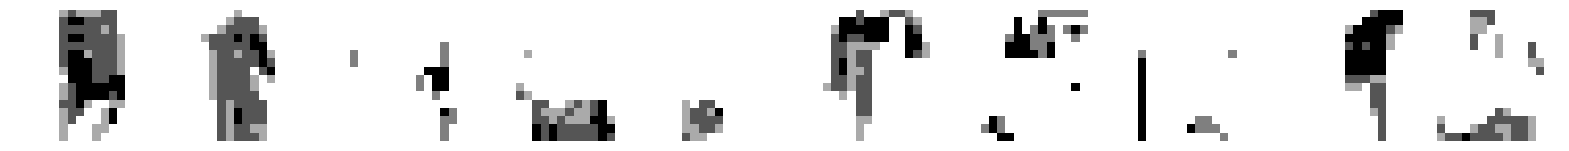

469/469 [==============================] - 29s 62ms/step - loss: 0.3981
Epoch 2/30
468/469 [============================>.] - ETA: 0s - loss: 0.3860
Saved to ./output/generated_img_001.png


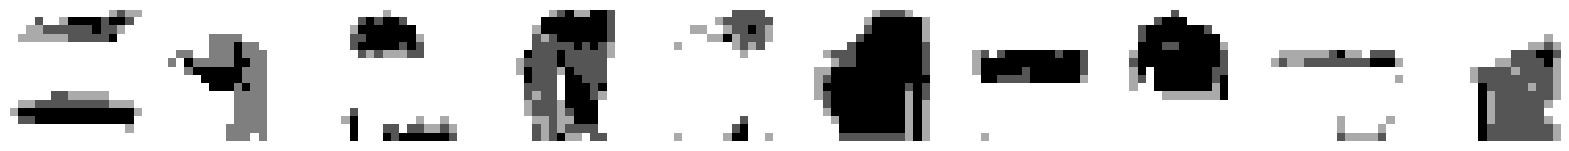

469/469 [==============================] - 31s 66ms/step - loss: 0.3860
Epoch 3/30
467/469 [============================>.] - ETA: 0s - loss: 0.3788
Saved to ./output/generated_img_002.png


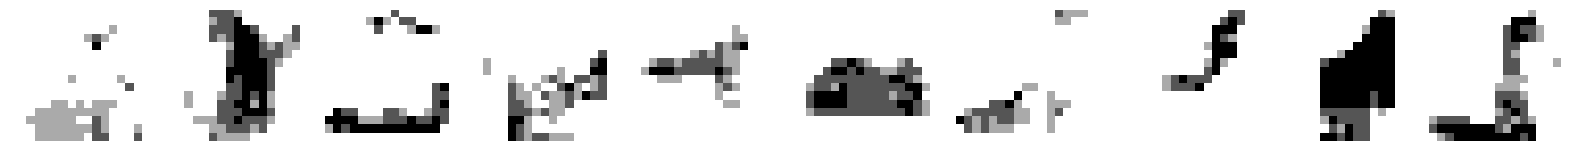

469/469 [==============================] - 30s 65ms/step - loss: 0.3788
Epoch 4/30
467/469 [============================>.] - ETA: 0s - loss: 0.3744
Saved to ./output/generated_img_003.png


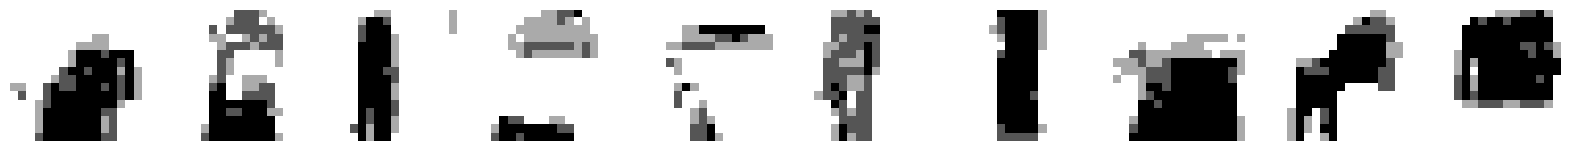

469/469 [==============================] - 29s 63ms/step - loss: 0.3744
Epoch 5/30
468/469 [============================>.] - ETA: 0s - loss: 0.3706
Saved to ./output/generated_img_004.png


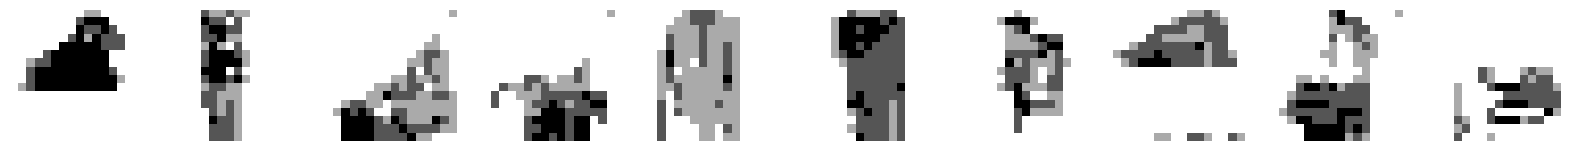

469/469 [==============================] - 30s 63ms/step - loss: 0.3706
Epoch 6/30
469/469 [==============================] - ETA: 0s - loss: 0.3679
Saved to ./output/generated_img_005.png


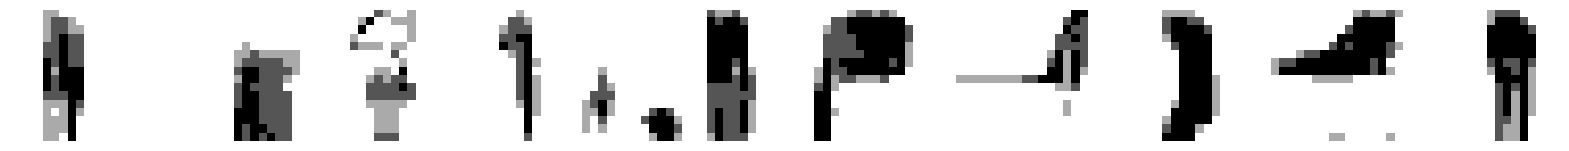

469/469 [==============================] - 29s 62ms/step - loss: 0.3679
Epoch 7/30
467/469 [============================>.] - ETA: 0s - loss: 0.3651
Saved to ./output/generated_img_006.png


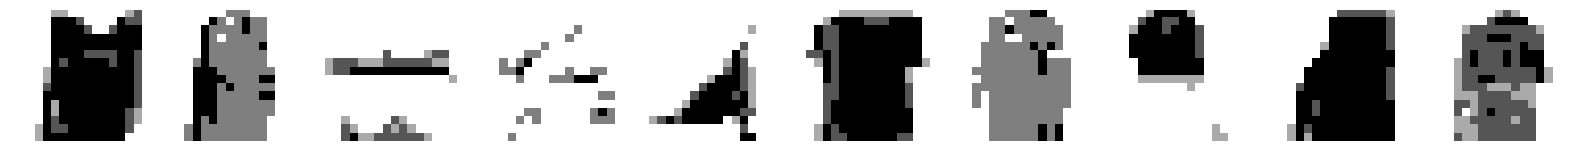

469/469 [==============================] - 31s 65ms/step - loss: 0.3651
Epoch 8/30
469/469 [==============================] - ETA: 0s - loss: 0.3631
Saved to ./output/generated_img_007.png


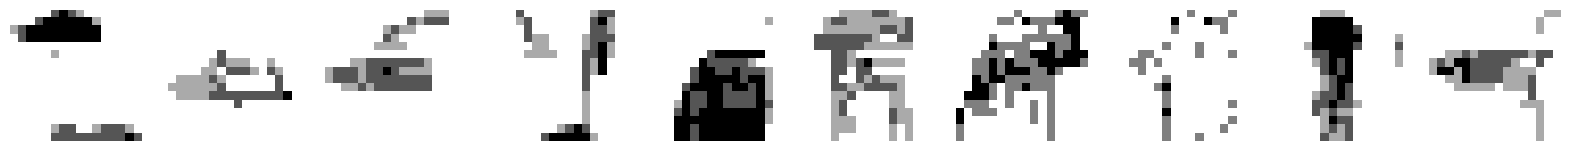

469/469 [==============================] - 30s 64ms/step - loss: 0.3631
Epoch 9/30
469/469 [==============================] - ETA: 0s - loss: 0.3608
Saved to ./output/generated_img_008.png


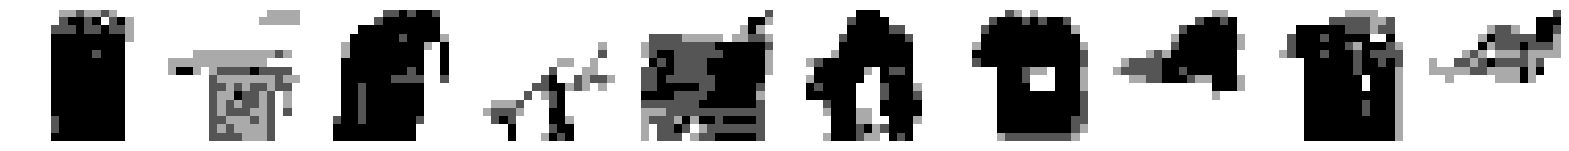

469/469 [==============================] - 32s 68ms/step - loss: 0.3608
Epoch 10/30
469/469 [==============================] - ETA: 0s - loss: 0.3587
Saved to ./output/generated_img_009.png


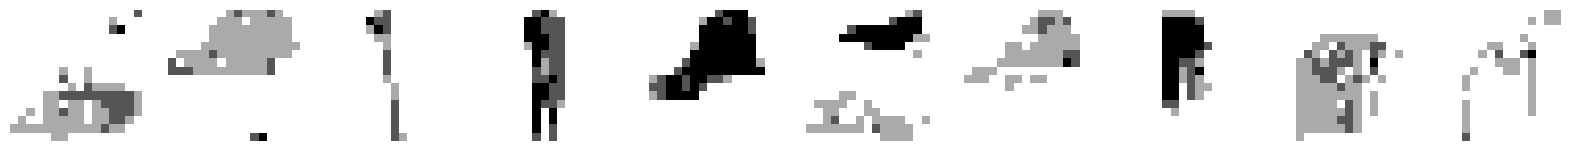

469/469 [==============================] - 29s 63ms/step - loss: 0.3587
Epoch 11/30
467/469 [============================>.] - ETA: 0s - loss: 0.3575
Saved to ./output/generated_img_010.png


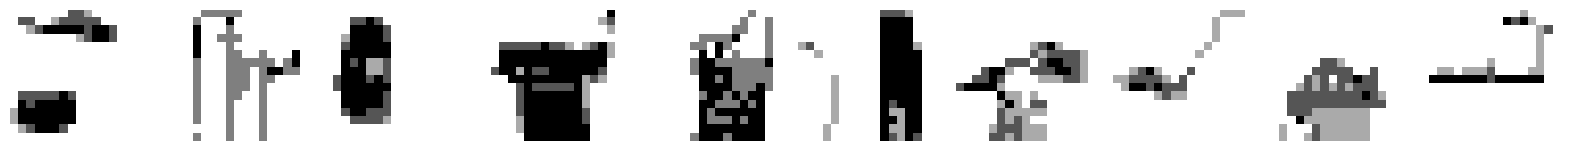

469/469 [==============================] - 29s 62ms/step - loss: 0.3575
Epoch 12/30
467/469 [============================>.] - ETA: 0s - loss: 0.3556
Saved to ./output/generated_img_011.png


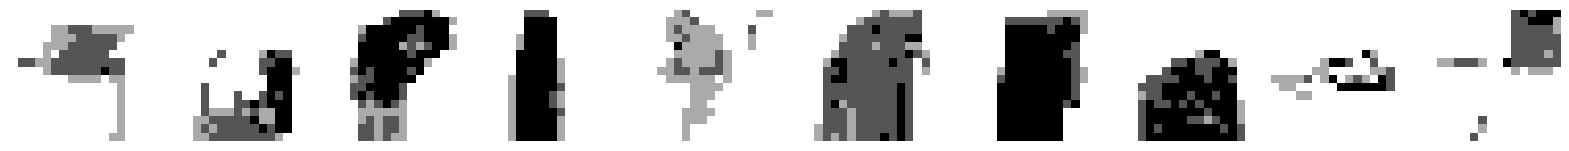

469/469 [==============================] - 29s 63ms/step - loss: 0.3556
Epoch 13/30
467/469 [============================>.] - ETA: 0s - loss: 0.3543
Saved to ./output/generated_img_012.png


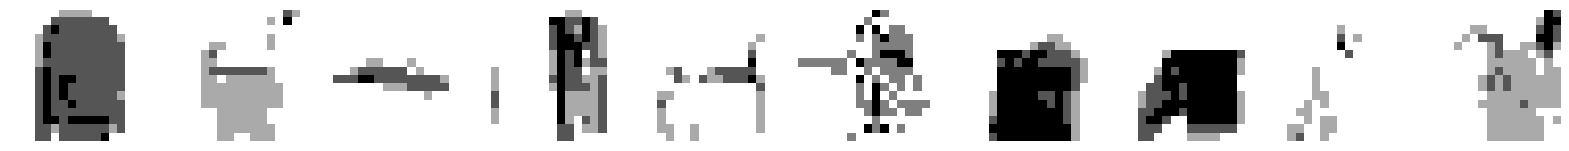

469/469 [==============================] - 29s 62ms/step - loss: 0.3543
Epoch 14/30
467/469 [============================>.] - ETA: 0s - loss: 0.3530
Saved to ./output/generated_img_013.png


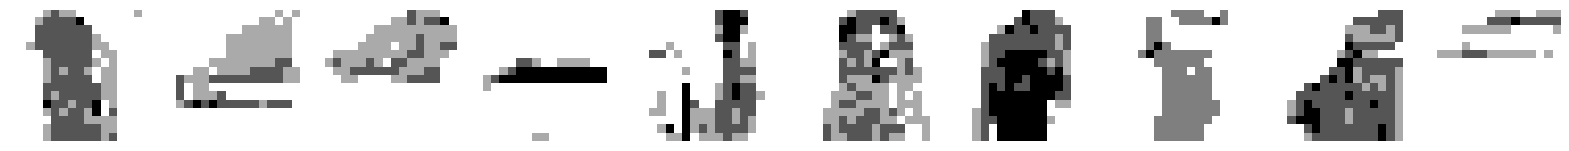

469/469 [==============================] - 29s 62ms/step - loss: 0.3530
Epoch 15/30
467/469 [============================>.] - ETA: 0s - loss: 0.3520
Saved to ./output/generated_img_014.png


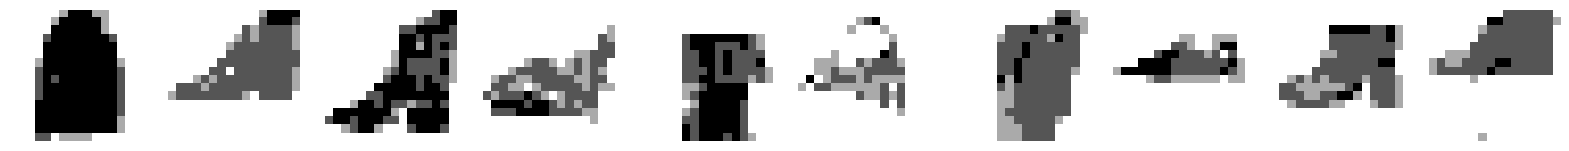

469/469 [==============================] - 30s 63ms/step - loss: 0.3520
Epoch 16/30
467/469 [============================>.] - ETA: 0s - loss: 0.3506
Saved to ./output/generated_img_015.png


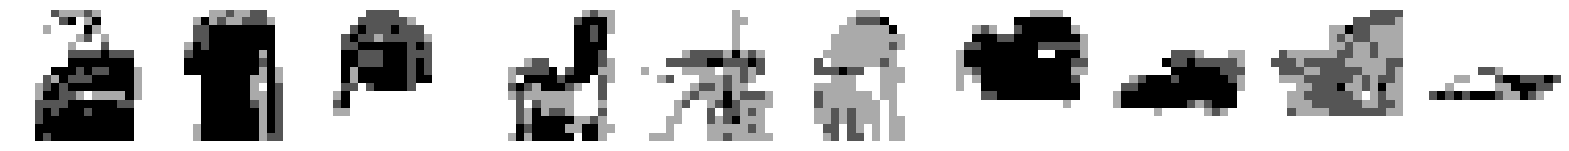

469/469 [==============================] - 30s 64ms/step - loss: 0.3506
Epoch 17/30
469/469 [==============================] - ETA: 0s - loss: 0.3497
Saved to ./output/generated_img_016.png


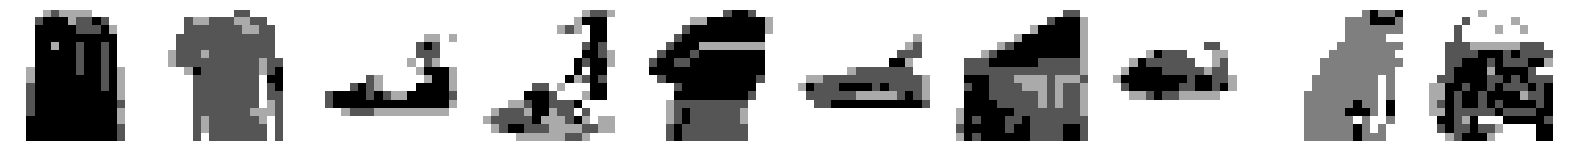

469/469 [==============================] - 30s 63ms/step - loss: 0.3497
Epoch 18/30
467/469 [============================>.] - ETA: 0s - loss: 0.3487
Saved to ./output/generated_img_017.png


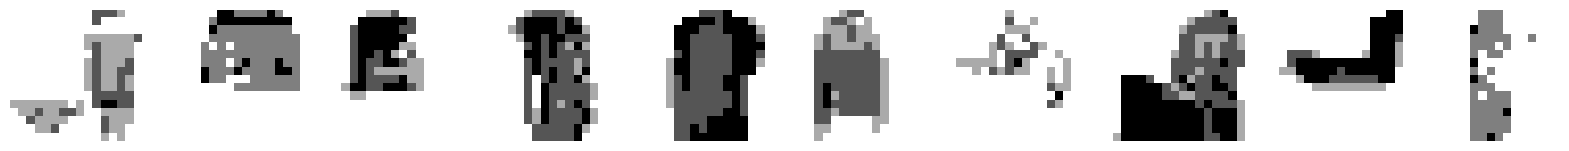

469/469 [==============================] - 30s 65ms/step - loss: 0.3488
Epoch 19/30
469/469 [==============================] - ETA: 0s - loss: 0.3479
Saved to ./output/generated_img_018.png


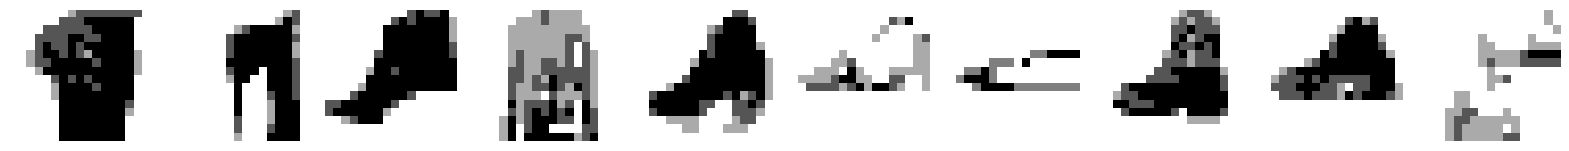

469/469 [==============================] - 30s 63ms/step - loss: 0.3479
Epoch 20/30
467/469 [============================>.] - ETA: 0s - loss: 0.3472
Saved to ./output/generated_img_019.png


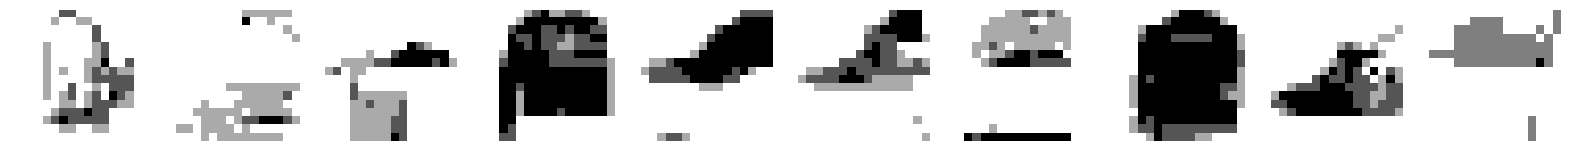

469/469 [==============================] - 30s 64ms/step - loss: 0.3472
Epoch 21/30
467/469 [============================>.] - ETA: 0s - loss: 0.3464
Saved to ./output/generated_img_020.png


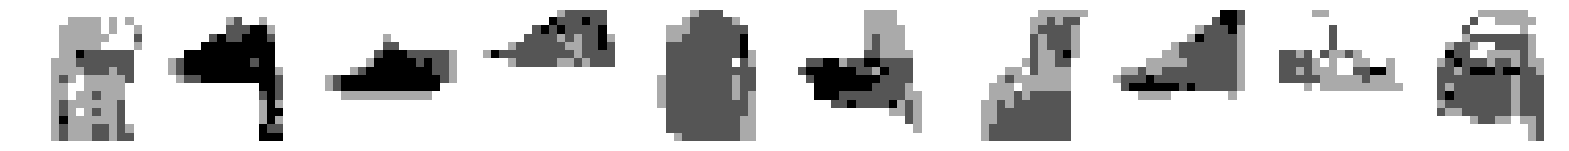

469/469 [==============================] - 29s 63ms/step - loss: 0.3464
Epoch 22/30
467/469 [============================>.] - ETA: 0s - loss: 0.3459
Saved to ./output/generated_img_021.png


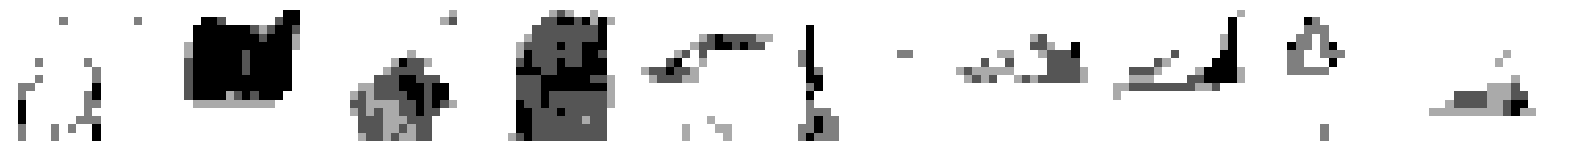

469/469 [==============================] - 32s 67ms/step - loss: 0.3459
Epoch 23/30
469/469 [==============================] - ETA: 0s - loss: 0.3450
Saved to ./output/generated_img_022.png


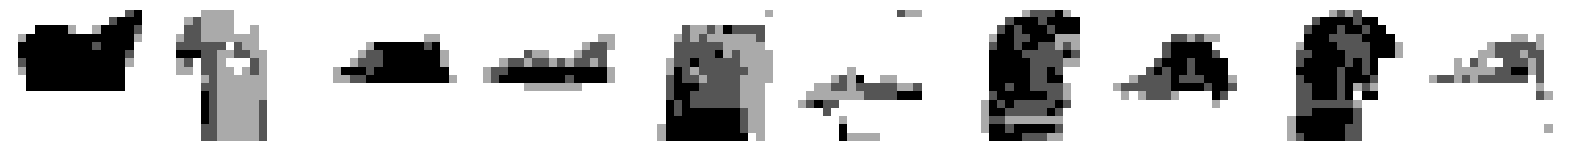

469/469 [==============================] - 31s 66ms/step - loss: 0.3450
Epoch 24/30
469/469 [==============================] - ETA: 0s - loss: 0.3444
Saved to ./output/generated_img_023.png


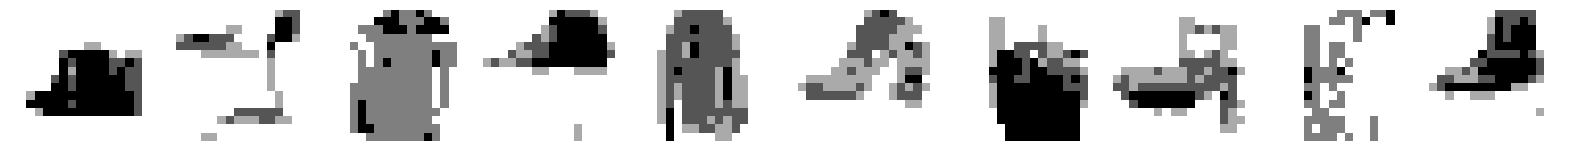

469/469 [==============================] - 30s 63ms/step - loss: 0.3444
Epoch 25/30
469/469 [==============================] - ETA: 0s - loss: 0.3436
Saved to ./output/generated_img_024.png


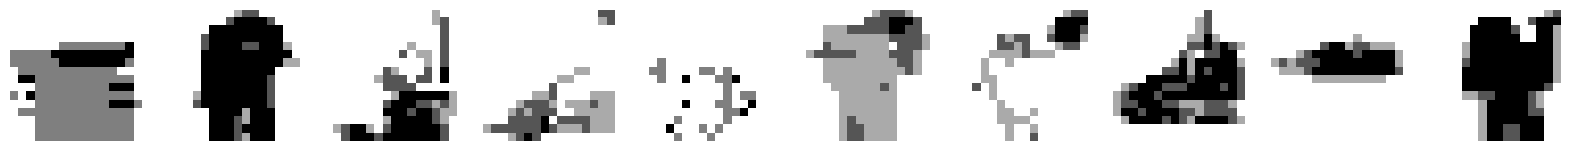

469/469 [==============================] - 30s 65ms/step - loss: 0.3436
Epoch 26/30
467/469 [============================>.] - ETA: 0s - loss: 0.3432
Saved to ./output/generated_img_025.png


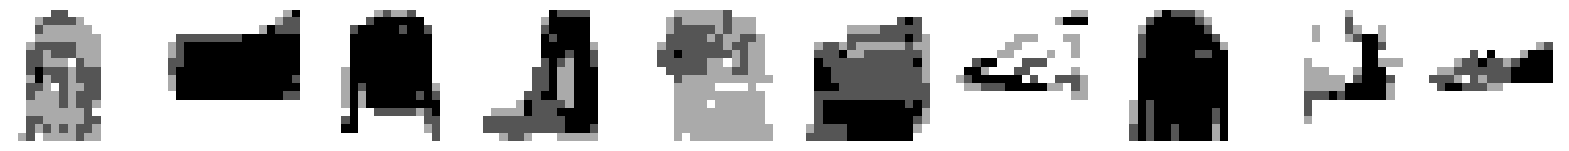

469/469 [==============================] - 29s 63ms/step - loss: 0.3432
Epoch 27/30
467/469 [============================>.] - ETA: 0s - loss: 0.3427
Saved to ./output/generated_img_026.png


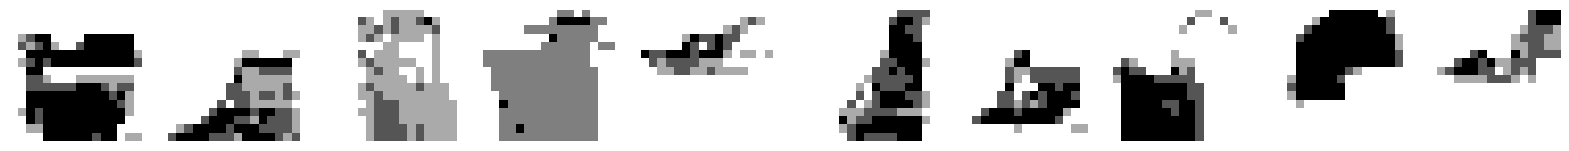

469/469 [==============================] - 30s 63ms/step - loss: 0.3427
Epoch 28/30
467/469 [============================>.] - ETA: 0s - loss: 0.3420
Saved to ./output/generated_img_027.png


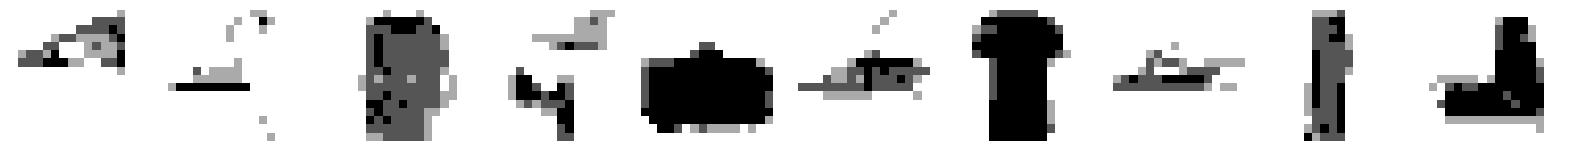

469/469 [==============================] - 30s 64ms/step - loss: 0.3420
Epoch 29/30
467/469 [============================>.] - ETA: 0s - loss: 0.3414
Saved to ./output/generated_img_028.png


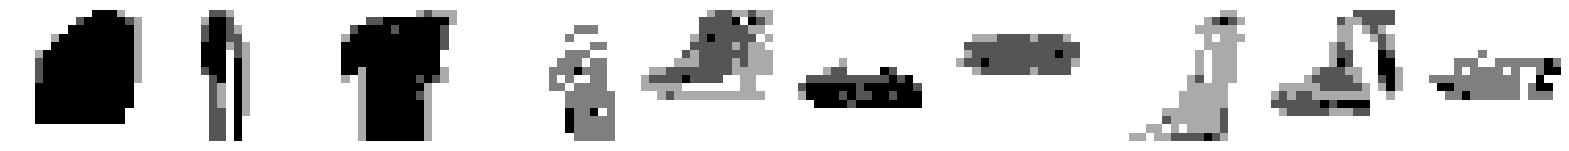

469/469 [==============================] - 30s 63ms/step - loss: 0.3414
Epoch 30/30
469/469 [==============================] - ETA: 0s - loss: 0.3409
Saved to ./output/generated_img_029.png


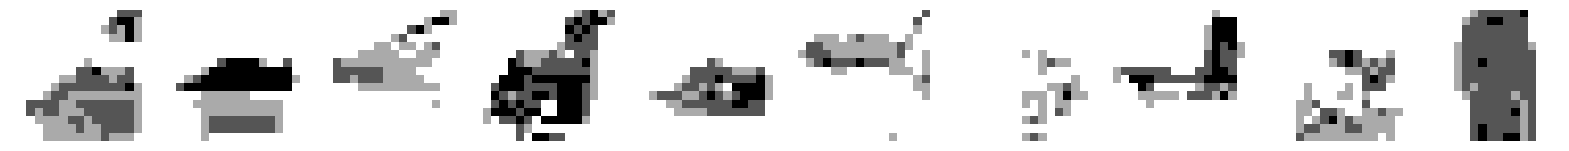

469/469 [==============================] - 30s 64ms/step - loss: 0.3409


In [ ]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=30,#EPOCHS,
    callbacks=[img_generator_callback], #tensorboard_callback
)

## 4. Generate images <a name="generate"></a>

In [ ]:
generated_images = img_generator_callback.generate(temperature=1.0)

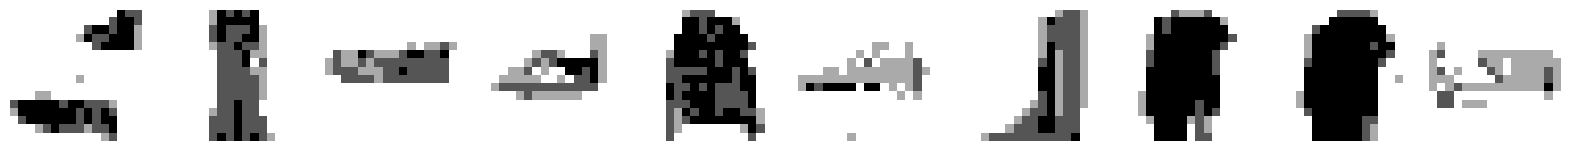

In [ ]:
display(generated_images)